# EDA and models
https://www.kaggle.com/artgor/eda-and-models

# 1st Step - import

In [1]:
%%time

import numpy as np
import pandas as pd
import os
pd.options.display.precision = 15
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model

import gc
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



CPU times: user 1.66 s, sys: 879 ms, total: 2.54 s
Wall time: 4.17 s


/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
%%time
folder_path = './input/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')
# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

CPU times: user 44.6 s, sys: 9.86 s, total: 54.4 s
Wall time: 54.9 s


In [3]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
del train_identity, train_transaction, test_identity, test_transaction

## Data Exploration
Let's start with identity information. id_01 - id_11 are continuous variables, id_12 - id_38 are categorical and the last two columns are obviously also categorical.

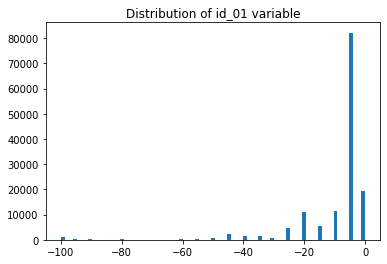

In [5]:
plt.hist(train['id_01'], bins=77);
plt.title('Distribution of id_01 variable');

In [6]:
train['id_01'].value_counts(dropna=False, normalize=True).head()

 NaN     0.755760829071697
-5.0     0.139143834456599
 0.0     0.033113760287195
-10.0    0.019062214244590
-20.0    0.018984319436448
Name: id_01, dtype: float64

In [7]:
train['id_02'].value_counts(dropna=False, normalize=True).head()

NaN       0.761452230162224
1102.0    0.000018627019338
696.0     0.000016933653944
1116.0    0.000015240288549
1120.0    0.000015240288549
Name: id_02, dtype: float64

In [8]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

NaN    0.887689233582822
0.0    0.108211128797372
1.0    0.001461374335354
3.0    0.001131168083449
2.0    0.000712906831036
Name: id_03, dtype: float64

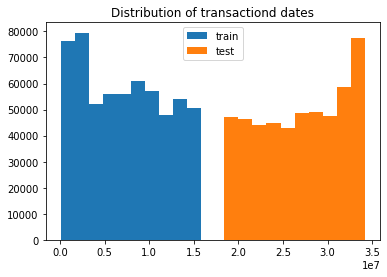

In [9]:
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution of transactiond dates');

In [10]:
%%time

train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

CPU times: user 35.6 s, sys: 28.3 s, total: 1min 3s
Wall time: 1min 4s


In [11]:
%%time
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)
test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)

CPU times: user 6.16 s, sys: 164 ms, total: 6.33 s
Wall time: 6.34 s


In [12]:
%%time
train['P_emaildomain'].str.split('.', expand=True).head()

CPU times: user 1.59 s, sys: 49.5 ms, total: 1.64 s
Wall time: 1.64 s


,0,1,2
0,NaN,NaN,NaN
1,gmail,com,None
2,outlook,com,None
3,yahoo,com,None
4,gmail,com,None


In [13]:
%%time
 train['R_emaildomain'].str.split('.', expand=True).head()

CPU times: user 1.74 s, sys: 30.1 ms, total: 1.77 s
Wall time: 1.77 s


,0,1,2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [14]:
%%time
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test

many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

CPU times: user 20.3 s, sys: 628 ms, total: 20.9 s
Wall time: 21.1 s


In [15]:
%%time
cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

CPU times: user 20 µs, sys: 1e+03 ns, total: 21 µs
Wall time: 21.9 µs


In [16]:
len(cols_to_drop)

84

In [17]:
%%time
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

CPU times: user 1.48 s, sys: 1.01 s, total: 2.49 s
Wall time: 2.49 s


In [18]:
%%time
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

CPU times: user 59.9 s, sys: 10.9 s, total: 1min 10s
Wall time: 1min 11s


In [19]:
%%time
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']

X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
test_id = test.sort_values('TransactionDT')['TransactionID']

CPU times: user 3.53 s, sys: 3.13 s, total: 6.65 s
Wall time: 7.12 s


In [20]:
del train, test

In [21]:
n_fold = 5
folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=5)

In [22]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          #'categorical_feature': cat_cols
         }

In [24]:
%%time
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 23,
    'min_data_in_leaf': 1,
    'num_iteration': 100,
    'verbose': -1
}

X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=0)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

# train
gbm = lgb.train(params,
            lgb_train,
            num_boost_round=50,
            valid_sets=lgb_eval,
            early_stopping_rounds=10)

[1]	valid_0's auc: 0.796586
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.815839
[3]	valid_0's auc: 0.846645
[4]	valid_0's auc: 0.853243
[5]	valid_0's auc: 0.860541
[6]	valid_0's auc: 0.864124
[7]	valid_0's auc: 0.866549
[8]	valid_0's auc: 0.867834
[9]	valid_0's auc: 0.869471
[10]	valid_0's auc: 0.870581
[11]	valid_0's auc: 0.87267
[12]	valid_0's auc: 0.873641
[13]	valid_0's auc: 0.874927
[14]	valid_0's auc: 0.876603
[15]	valid_0's auc: 0.877705
[16]	valid_0's auc: 0.880365
[17]	valid_0's auc: 0.881965
[18]	valid_0's auc: 0.8822
[19]	valid_0's auc: 0.883157
[20]	valid_0's auc: 0.88403
[21]	valid_0's auc: 0.884858
[22]	valid_0's auc: 0.885821
[23]	valid_0's auc: 0.886423
[24]	valid_0's auc: 0.887381
[25]	valid_0's auc: 0.888356
[26]	valid_0's auc: 0.888956
[27]	valid_0's auc: 0.889482
[28]	valid_0's auc: 0.890826
[29]	valid_0's auc: 0.891549
[30]	valid_0's auc: 0.892051
[31]	valid_0's auc: 0.892911
[32]	valid_0's auc: 0.893758
[33]	valid_0's auc: 0.8

In [26]:
%%time
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
#y_pred = np.argmax(y_pred, axis=1)

CPU times: user 11.5 s, sys: 2.36 s, total: 13.8 s
Wall time: 9.37 s


In [28]:
y_pred

array([0.00299331, 0.00883212, 0.01721653, ..., 0.010387  , 0.01567842,
       0.01183336])

In [31]:
submit = pd.DataFrame({'TransactionID':test_id,
              'isFraud': y_pred})

In [34]:
submit.to_csv('20190801.csv', index=False)